# MultiLayer-Perceptron

## Imports

In [1]:
import numpy as np 
import shutil # pour les dossiers
import pandas as pd
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import copy

## Chargement des images

In [2]:
def metrique(path):
    files = os.listdir(path);
    contenu = [];
    for file in files:
        if file.endswith('.json'):
            openFile = open(path+file, "r");
            contenu.append(json.loads(openFile.read())["Image"]);
            openFile.close();
    return contenu;

In [3]:
chemin = "./train/";
contenu = [];
if not os.path.isdir(chemin):
    print('Rajouter le dossier train dans le dossier courant :) ! ');
else :
    contenu = metrique(chemin);
    df = pd.DataFrame(contenu)
    # on laisse Species car c'est égale au nombre de classe
    df.drop(["Genus","ClassId","Family","Vote","Location","Latitude","Longitude","Date","Author","Content","MediaId", "LearnTag", "ImageId2014","ObservationId2014","YearInCLEF","ObservationId"], axis='columns', inplace=True)
    df = df.drop_duplicates()
    classe  = df.to_numpy();
    print(len(classe))


50


## On récupère le nom des PNG ainsi que leur classe

In [4]:
X = [];
Y = [];
files = os.listdir("./train")
for file in files:
    if file.endswith('.jpg'):
        X.append(file);
        nameFile = file.split('.')[0];
        for file_class in files:
            nameFileAutre = file_class.split('.')[0];
            if nameFile==nameFileAutre and file_class.endswith('.json'):
                fichierSrc = open("./train/"+file_class, "r");
                contenu = fichierSrc.read();
                monJson = json.loads(contenu)
                Y.append(monJson["Image"]["Species"])
                break;


In [5]:
# on a bien une classe par image !
if(len(X) == len(Y)):
    print("OK")
else:
    print("KO")

OK


In [6]:
# 60% train 20% test 20% val
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42, stratify=Y)
y_train[0]

'Salix caprea L.'

## Mise en place de l'architecture dossier pour avoir les image_datasets

In [7]:
# Création des répertoires ! 
directory = "MLP"
for classe in y_train : 
    if(not os.path.isdir('./MLP/train/'+classe)):
        os.mkdir('./MLP/train/'+classe)
        
for classe in y_test : 
    if(not os.path.isdir('./MLP/val/'+classe)):
        os.mkdir('./MLP/val/'+classe)
        
# on met les images dans les répertoires precédents

# on supprime le contenu

directorys=os.listdir('./MLP/train/')
for i in range(0,len(directory)):
    files=os.listdir('./MLP/train/'+directorys[i])
    for j in range(0,len(files)):
        os.remove('./MLP/train/'+directorys[i]+'/'+files[j])

directorys=os.listdir('./MLP/val/')
for i in range(0,len(directory)):
    files=os.listdir('./MLP/val/'+directorys[i])
    for j in range(0,len(files)):
        os.remove('./MLP/val/'+directorys[i]+'/'+files[j])

# on met le contenu
shutil.copyfile('./train/'+X_train[0],'./MLP/train/'+y_train[0]+'/'+X_train[0])

print('./MLP/train/'+y_train[0]+X_train[0])
print(X_train[0])
for i in range(len(X_train)):
    shutil.copyfile('./train/'+X_train[i],'./MLP/train/'+y_train[i]+'/'+X_train[i])
    
for i in range(len(X_test)):
    shutil.copyfile('./train/'+X_test[i],'./MLP/val/'+y_test[i]+'/'+X_test[i])
    

./MLP/train/Salix caprea L.63696.jpg
63696.jpg


## Mise en place du MLP

In [8]:
# Normalisation des données
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'MLP'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Modèle du MLP

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dims, output_dim):
        super().__init__()
        
        assert len(hid_dims) > 0
        
        self.input_fc = nn.Linear(input_dim, hid_dims[0])
        
        self.fcs = nn.ModuleList([nn.Linear(hid_dims[i], hid_dims[i+1]) 
                                  for i in range(len(hid_dims)-1)])
        
        self.output_fc = nn.Linear(hid_dims[-1], output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        x = x.view(x.shape[0], -1)
        
        #x = [batch size, height * width]
        
        x = F.relu(self.input_fc(x))
        
        #x = [batch size, hid dims[0]]
        
        for fc in self.fcs:
            x = F.relu(fc(x))
        
        #x = [batch size, hid dims[-1]]
        
        x = self.output_fc(x)
        
        #x = [batch size, output dim]
        
        return x

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    evolution_accuracy = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            evolution_accuracy.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print("Evolution de l'accuracy pour savoir si on doit augmenter l'époch : ")
    plt.plot(evolution_accuracy)
    plt.ylabel('Evolution accuracy par epoch')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Paramètrage du modèle avec différentes couches et nodes

### Modèle à 6 couches cachées avec peu de nodes

Epoch 0/19
----------
train Loss: 3.9047 Acc: 0.0335
val Loss: 3.8467 Acc: 0.0506

Epoch 1/19
----------
train Loss: 3.7926 Acc: 0.0602
val Loss: 3.6983 Acc: 0.0645

Epoch 2/19
----------
train Loss: 3.6619 Acc: 0.0670
val Loss: 3.4760 Acc: 0.1212

Epoch 3/19
----------
train Loss: 3.4728 Acc: 0.0924
val Loss: 3.3548 Acc: 0.1011

Epoch 4/19
----------
train Loss: 3.3756 Acc: 0.1057
val Loss: 3.3359 Acc: 0.1177

Epoch 5/19
----------
train Loss: 3.3386 Acc: 0.1023
val Loss: 3.1925 Acc: 0.1186

Epoch 6/19
----------
train Loss: 3.2918 Acc: 0.1135
val Loss: 3.1592 Acc: 0.1229

Epoch 7/19
----------
train Loss: 3.1556 Acc: 0.1341
val Loss: 3.0070 Acc: 0.1587

Epoch 8/19
----------
train Loss: 3.1146 Acc: 0.1405
val Loss: 2.9740 Acc: 0.1648

Epoch 9/19
----------
train Loss: 3.1030 Acc: 0.1526
val Loss: 2.9567 Acc: 0.1718

Epoch 10/19
----------
train Loss: 3.1064 Acc: 0.1427
val Loss: 2.9293 Acc: 0.1770

Epoch 11/19
----------
train Loss: 3.0724 Acc: 0.1500
val Loss: 2.9092 Acc: 0.1656

Ep

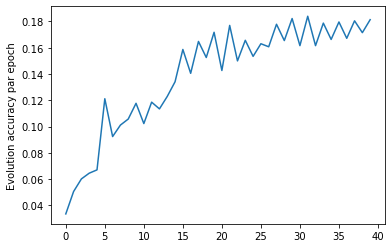

In [24]:
INPUT_DIM = 3 * 224 * 224 # correspond à la taille d'une image précedemment normalisée
HID_DIMS = [512, 256, 128, 64, 32, 16] # Tableau de layers, chacun exprimant le nombre de node utilisée
OUTPUT_DIM = 50 # Dimension finale
model_ft = MLP(INPUT_DIM, HID_DIMS, OUTPUT_DIM)

class_names = image_datasets['train'].classes

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

best_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)

### Modèle à 6 couches cachées avec beaucoup de nodes

Epoch 0/19
----------
train Loss: 3.9117 Acc: 0.0245
val Loss: 3.9014 Acc: 0.0279

Epoch 1/19
----------
train Loss: 3.8853 Acc: 0.0567
val Loss: 3.8118 Acc: 0.0889

Epoch 2/19
----------
train Loss: 3.6710 Acc: 0.0859
val Loss: 3.4869 Acc: 0.0915

Epoch 3/19
----------
train Loss: 3.4834 Acc: 0.1014
val Loss: 3.3279 Acc: 0.1168

Epoch 4/19
----------
train Loss: 3.3708 Acc: 0.1104
val Loss: 3.2185 Acc: 0.1325

Epoch 5/19
----------
train Loss: 3.2681 Acc: 0.1289
val Loss: 3.0420 Acc: 0.1726

Epoch 6/19
----------
train Loss: 3.2235 Acc: 0.1289
val Loss: 3.0685 Acc: 0.1691

Epoch 7/19
----------
train Loss: 3.0893 Acc: 0.1637
val Loss: 2.8831 Acc: 0.1892

Epoch 8/19
----------
train Loss: 3.0037 Acc: 0.1715
val Loss: 2.8398 Acc: 0.2005

Epoch 9/19
----------
train Loss: 3.0077 Acc: 0.1861
val Loss: 2.8162 Acc: 0.2084

Epoch 10/19
----------
train Loss: 2.9867 Acc: 0.1728
val Loss: 2.7957 Acc: 0.2014

Epoch 11/19
----------
train Loss: 2.9499 Acc: 0.1839
val Loss: 2.7860 Acc: 0.2119

Ep

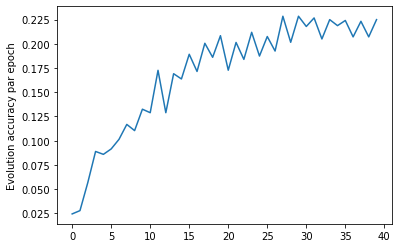

In [12]:
INPUT_DIM = 3 * 224 * 224 # correspond à la taille d'une image précedemment normalisée
HID_DIMS = [1024, 512, 256, 128, 64, 32] # Tableau de layers, chacun exprimant le nombre de node utilisée
OUTPUT_DIM = 50 # Dimension finale
model_ft = MLP(INPUT_DIM, HID_DIMS, OUTPUT_DIM)

class_names = image_datasets['train'].classes

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

best_model2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)

### Modèle à 3 couches cachées avec peu de nodes

Epoch 0/19
----------
train Loss: 3.6121 Acc: 0.0928
val Loss: 3.2689 Acc: 0.1247

Epoch 1/19
----------
train Loss: 3.3419 Acc: 0.1199
val Loss: 3.1082 Acc: 0.1613

Epoch 2/19
----------
train Loss: 3.2128 Acc: 0.1538
val Loss: 3.0290 Acc: 0.1665

Epoch 3/19
----------
train Loss: 3.1223 Acc: 0.1672
val Loss: 3.0125 Acc: 0.1831

Epoch 4/19
----------
train Loss: 3.0726 Acc: 0.1680
val Loss: 2.8172 Acc: 0.2276

Epoch 5/19
----------
train Loss: 3.0353 Acc: 0.1831
val Loss: 2.8246 Acc: 0.2014

Epoch 6/19
----------
train Loss: 2.9334 Acc: 0.2020
val Loss: 2.7539 Acc: 0.2467

Epoch 7/19
----------
train Loss: 2.8025 Acc: 0.2338
val Loss: 2.5562 Acc: 0.2816

Epoch 8/19
----------
train Loss: 2.6671 Acc: 0.2566
val Loss: 2.5103 Acc: 0.2790

Epoch 9/19
----------
train Loss: 2.6204 Acc: 0.2651
val Loss: 2.4867 Acc: 0.2825

Epoch 10/19
----------
train Loss: 2.5478 Acc: 0.2879
val Loss: 2.4597 Acc: 0.3043

Epoch 11/19
----------
train Loss: 2.5296 Acc: 0.2974
val Loss: 2.4536 Acc: 0.3069

Ep

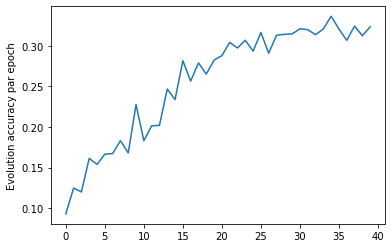

In [13]:
INPUT_DIM = 3 * 224 * 224
HID_DIMS = [1000, 500, 250]
OUTPUT_DIM = 50
model_ft = MLP(INPUT_DIM, HID_DIMS, OUTPUT_DIM)

class_names = image_datasets['train'].classes

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

best_model3 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)

### Modèle à 3 couches cachées avec beaucoup de nodes

Epoch 0/19
----------
train Loss: 3.6195 Acc: 0.0851
val Loss: 3.2777 Acc: 0.1160

Epoch 1/19
----------
train Loss: 3.2941 Acc: 0.1418
val Loss: 3.1296 Acc: 0.1656

Epoch 2/19
----------
train Loss: 3.2078 Acc: 0.1474
val Loss: 2.9449 Acc: 0.1866

Epoch 3/19
----------
train Loss: 3.1373 Acc: 0.1556
val Loss: 2.8734 Acc: 0.2066

Epoch 4/19
----------
train Loss: 3.0568 Acc: 0.1685
val Loss: 2.8967 Acc: 0.1962

Epoch 5/19
----------
train Loss: 2.9703 Acc: 0.1925
val Loss: 2.8173 Acc: 0.2223

Epoch 6/19
----------
train Loss: 2.9539 Acc: 0.2041
val Loss: 2.7555 Acc: 0.2284

Epoch 7/19
----------
train Loss: 2.7178 Acc: 0.2372
val Loss: 2.5353 Acc: 0.2973

Epoch 8/19
----------
train Loss: 2.6160 Acc: 0.2664
val Loss: 2.4779 Acc: 0.3078

Epoch 9/19
----------
train Loss: 2.5733 Acc: 0.2750
val Loss: 2.4679 Acc: 0.3278

Epoch 10/19
----------
train Loss: 2.5763 Acc: 0.2819
val Loss: 2.4440 Acc: 0.3357

Epoch 11/19
----------
train Loss: 2.5021 Acc: 0.3051
val Loss: 2.4327 Acc: 0.3287

Ep

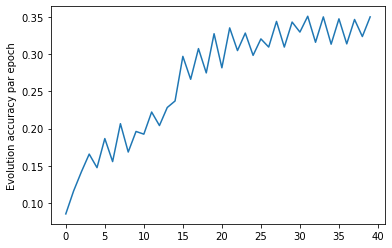

In [12]:
INPUT_DIM = 3 * 224 * 224 # correspond à la taille d'une image précedemment normalisée
HID_DIMS = [2000, 1000, 500] # Tableau de layers, chacun exprimant le nombre de node utilisée
OUTPUT_DIM = 50 # Dimension finale
model_ft = MLP(INPUT_DIM, HID_DIMS, OUTPUT_DIM)

class_names = image_datasets['train'].classes

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

best_model4 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)

### Modèle à couche cachée unique et nombre identique de nodes à notre meilleure modèle équilibré

Epoch 0/19
----------
train Loss: 6120.0032 Acc: 0.0447
val Loss: 37037.0211 Acc: 0.0558

Epoch 1/19
----------
train Loss: 37612116.4142 Acc: 0.0387
val Loss: 155957313.5031 Acc: 0.0506

Epoch 2/19
----------
train Loss: 153223924440.2372 Acc: 0.0430
val Loss: 1518122403620.3801 Acc: 0.0445

Epoch 3/19
----------
train Loss: 612478377938882.3750 Acc: 0.0335
val Loss: 2695438091503982.0000 Acc: 0.0488

Epoch 4/19
----------
train Loss: 2251333073696358656.0000 Acc: 0.0408
val Loss: 10718914305147226112.0000 Acc: 0.0671

Epoch 5/19
----------
train Loss: 7480934344078033682432.0000 Acc: 0.0400
val Loss: 32736122382564626268160.0000 Acc: 0.0549

Epoch 6/19
----------
train Loss: 16385575089031576041816064.0000 Acc: 0.0498
val Loss: 122003795982826999260381184.0000 Acc: 0.0262

Epoch 7/19
----------
train Loss: 39109915440188841915318272.0000 Acc: 0.0679
val Loss: 10770241180136709480775680.0000 Acc: 0.1072

Epoch 8/19
----------
train Loss: 17001569373129702876643328.0000 Acc: 0.0847
val

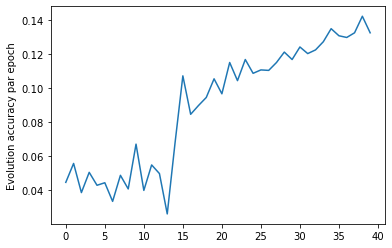

In [12]:
INPUT_DIM = 3 * 224 * 224
HID_DIMS = [1750]
OUTPUT_DIM = 50
model_ft = MLP(INPUT_DIM, HID_DIMS, OUTPUT_DIM)

class_names = image_datasets['train'].classes

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

best_model5 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)

## Matrice de confusion du meilleur modèle

torch.Size([50, 50])


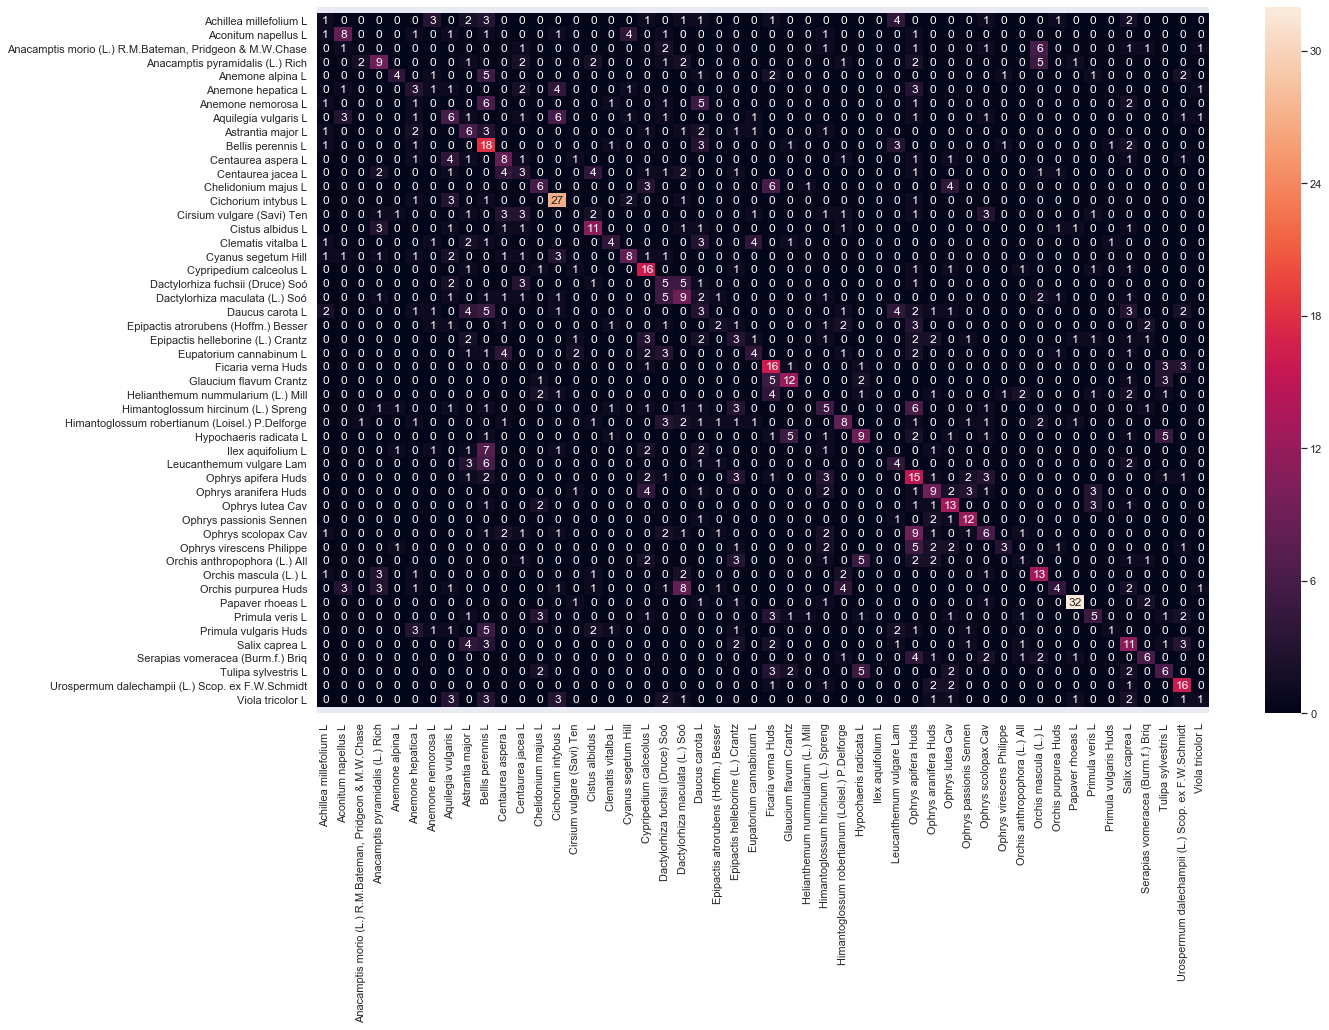

In [14]:
nb_classes = len(class_names)

normalize = False

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = best_model3(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.shape)
# On affiche la matrice de confusion, normalisé ou non 
if normalize : 
    confusion_matrix = confusion_matrix.numpy()
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
plt.figure(figsize=(20, 13))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix, annot=True, xticklabels= class_names, yticklabels= class_names)

# correction du bug qui coupé le haut et le bas de la matrice de confusion
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show()

In [15]:
PATH = './MLP/bestModel.pth'
torch.save(best_model3, PATH)

c:\users\lawl\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\lawl\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\lawl\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Test du modèle sur de nouvelles images

In [16]:
if(not os.path.isdir('./MLP/test')):
    os.mkdir('./MLP/test')
    

for classe in y_test : 
    if(not os.path.isdir('./MLP/test/'+classe)):
        os.mkdir('./MLP/test/'+classe)

directorys=os.listdir('./MLP/test/')
for i in range(0,len(directorys)):
    files=os.listdir('./MLP/test/'+directorys[i])
    for j in range(0,len(files)):
        os.remove('./MLP/test/'+directorys[i]+'/'+files[j])


for i in range(len(X_test)):
    shutil.copyfile('./train/'+X_test[i],'./MLP/test/'+y_test[i]+'/'+X_test[i])

In [17]:
PATH = 'MLP/bestModel.pth'
our_model = torch.load(PATH)
our_model.to(device)
optimizer = optim.SGD(our_model.parameters(), lr=0.001, momentum=0.9)

In [18]:
correct = 0
total = 0
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data = datasets.ImageFolder('./MLP/test/', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data)

Accuracy of the network on test images: 32 %


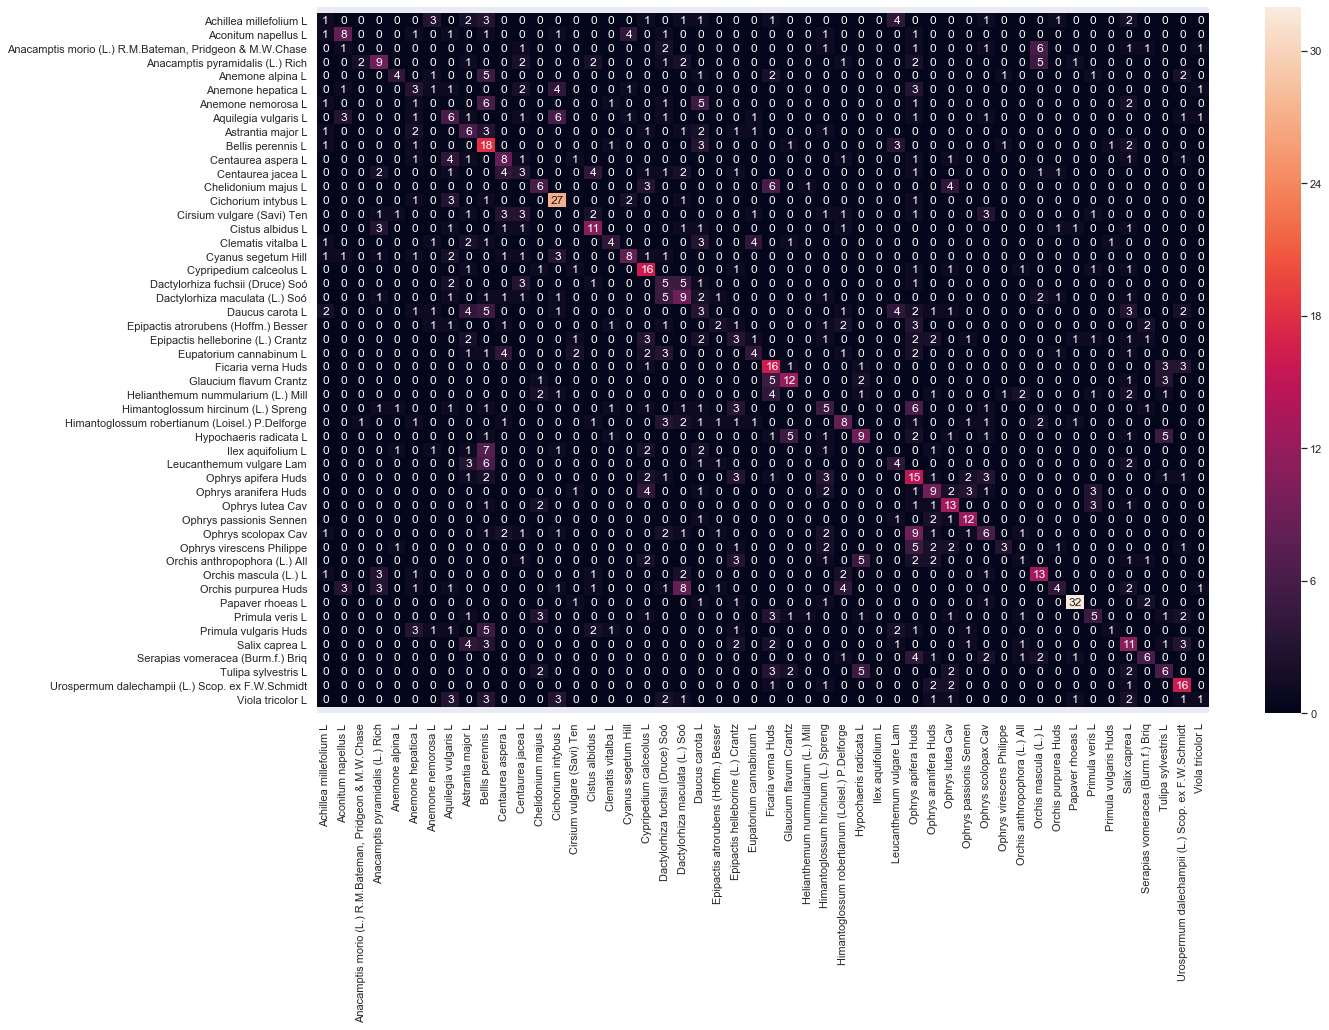

In [20]:
correct = 0
total = 0
nb_classes = len(test_data.classes)
class_names = test_data.classes
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        images = inputs.to(device)
        labels = classes.to(device)
        outputs = our_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1


print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

plt.figure(figsize=(20, 13))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix, annot=True, xticklabels= class_names, yticklabels= class_names)

# correction du bug qui coupé le haut et le bas de la matrice de confusion
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show()